In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir("..")

In [3]:
%matplotlib inline

In [4]:
data = pd.read_excel('data/Raw_growth_data2.xlsx',sheetname='Raw data (OD600)SLIM',skiprows=[0],index_col=None)

In [5]:
skip_strains = ['ura3_EV', u'cspD1_EV', u'cspD1_cspD1','ura3']

In [6]:
if not 'figures' in os.listdir('.'):
    os.mkdir('figures')
    os.mkdir('figures/data')
    os.mkdir('figures/data/standard')
    os.mkdir('figures/data/osmotic')
    os.mkdir('figures/data/heatshock')
    os.mkdir('figures/data/paraquat')
    os.mkdir('figures/data/peroxide')

## Update labels 

In [7]:
# update all strains to same label
data.loc[data.Strain==1179,'Strain'] = 'copR'
data.loc[data.Strain=='VNG1179','Strain'] = 'copR'
data.loc[data.Strain=='VNG1179C','Strain'] = 'copR'
data.loc[data.Strain=='VNG0194','Strain'] = 'VNG0194H'

In [8]:
# add indicator columns for each condition
data['standard'] = (data.Condition.isnull()).astype(int)
data['paraquat'] = (data.Condition=='0.333mM PQ').astype(int)
data['peroxide'] = (data.Condition=='5mM H2O2').astype(int)
data['osmotic'] = (data.Condition=='2.9M NaCl').astype(int)
data['heatshock'] = (data.Condition=='54C shift at 16h').astype(int)

# tidy 

In [9]:
# convert data to tidy formay
tidy = pd.melt(data,id_vars=['Experiment','Well','Strain','Biological replicate','Technical Replicate','standard','paraquat','peroxide','osmotic','heatshock'],value_vars=data.columns.values[7:-5].tolist(),value_name='OD',var_name='time')
tidy = tidy[~tidy.OD.isnull()]
tidy.shape

(264372, 12)

In [10]:
tidy.head()

,Experiment,Well,Strain,Biological replicate,Technical Replicate,standard,paraquat,peroxide,osmotic,heatshock,time,OD
0,PQ_2,102,copR,A,NaN,1,0,0,0,0,0,0.092
1,PQ_2,103,copR,A,NaN,1,0,0,0,0,0,0.093
2,PQ_2,104,copR,A,NaN,1,0,0,0,0,0,0.093
3,PQ_2,105,copR,B,NaN,1,0,0,0,0,0,0.089
4,PQ_2,106,copR,B,NaN,1,0,0,0,0,0,0.091


# Plot

## Standard 

In [11]:
def plot_standard(norm,method):
    
    if not method in os.listdir("figures/data/standard/"):
        os.mkdir("figures/data/standard/"+method)

    standard = norm[norm.standard==1]
    g = standard.groupby('Strain')

    ura3 = g.get_group('ura3')
    g_ura3 = ura3.groupby(['Experiment','Well'])

    for strain,temp in g:
        g2 = temp.groupby(['Experiment','Well'])

        plt.figure(figsize=(8,6))

#         plt.subplot(121)
#         for well,temp2 in g_ura3:
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'k',alpha=.2)    

#         plt.subplot(122)
        for well,temp2 in g2:
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.title(strain,fontsize=35)

#         plt.subplot(121)
        plt.ylabel("log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
#         plt.xlim(standard.time.min(),standard.time.max())
        
        ylim = (min(ura3.OD.min(),standard.OD.min(),),
                max(ura3.OD.max(),standard.OD.max(),))
        plt.ylim(ylim)
        
#         plt.subplot(122)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.xticks(fontsize=25)
#         plt.grid(True,color='grey')
#         plt.xlim(-1,44)

        plt.savefig("figures/data/standard/%s/%s"%(method,strain),bbox_inches='tight',dpi=150)
        plt.close()

In [23]:
def plotConditions(norm,method,conditions,subplots=None):
    
    if subplots is None:
        subplots = (1,len(conditions))
    
    if not '-'.join(conditions) in os.listdir("figures/data/"):
        os.mkdir("figures/data/%s/"%'-'.join(conditions))
    
    if not method in os.listdir("figures/data/%s/"%'-'.join(conditions)):
        os.mkdir("figures/data/%s/"%'-'.join(conditions)+method)
        
    strains = norm.Strain.unique()
    ylim = (np.inf,-np.inf)

    for strain in strains:
        plt.figure(figsize=(6*subplots[1],6*subplots[0]))
        
        for i,condition in enumerate(conditions):

            paraquat = norm.loc[(norm[condition]==1),:]
            g = paraquat.groupby('Strain')

            ura3 = g.get_group('ura3')
            _condition = g.get_group(strain)

            plt.subplot(subplots[0],subplots[1],i+1)

            for well,temp2 in ura3.groupby(['Experiment','Well']):
                temp2.sort_values('time')
                plt.plot(temp2.time,temp2.OD,'k',alpha=.8,lw=2)

            for well,temp2 in _condition.groupby(['Experiment','Well']):
                temp2.sort_values('time')
                plt.plot(temp2.time,temp2.OD,'limegreen',alpha=.8,lw=2)
                
            ylim = (min(ylim[0],ura3.OD.min().min()),max(ylim[1],ura3.OD.max().max()))
            ylim = (min(ylim[0],_condition.OD.min().min()),max(ylim[1],_condition.OD.max().min()))

            plt.title(condition,fontsize=30)
            if i == 0:
                plt.ylabel("log(OD)",fontsize=30)
            plt.xlabel("time (h)",fontsize=30)
            plt.yticks(fontsize=25)
            plt.xticks(fontsize=25)
            
        for i in range(len(conditions)):
            plt.subplot(subplots[0],subplots[1],i+1)
            plt.ylim(ylim)

        plt.tight_layout()

        plt.savefig("figures/data/%s/%s/%s"%('-'.join(conditions),method,strain),bbox_inches='tight',dpi=150, transparent=True)
        plt.close()

KeyError: u'ura3_EV'

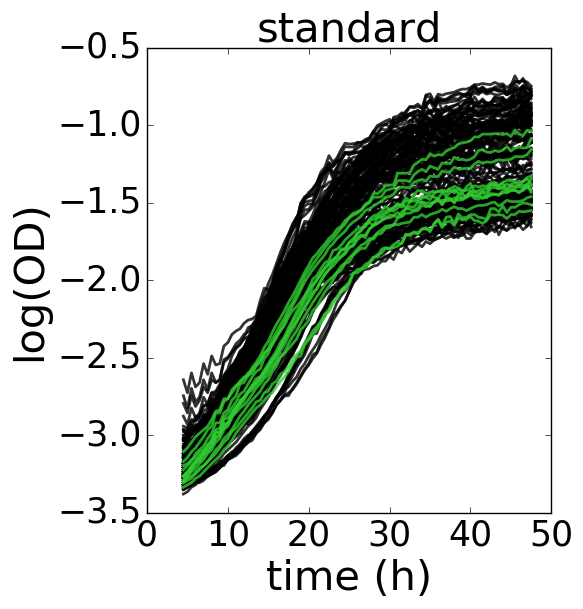

In [24]:
plotConditions(norm,'log2',['standard','paraquat','osmotic','peroxide'])

KeyError: u'ura3_EV'

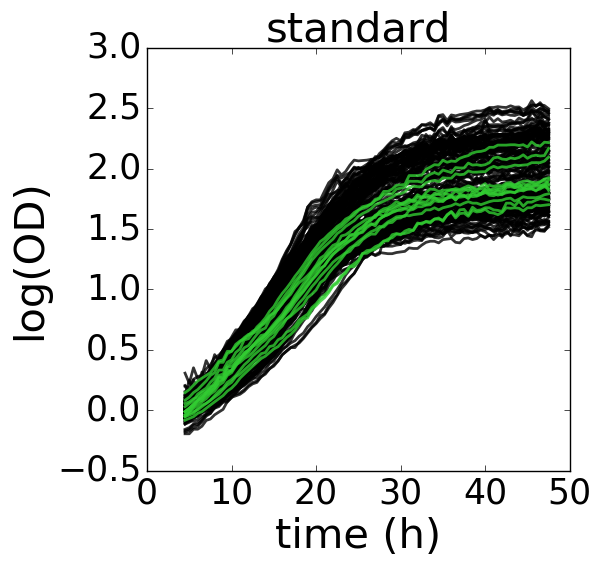

In [47]:
plotConditions(norm,'log2_st0',['standard','paraquat','osmotic','peroxide'],subplots=(2,2))

KeyError: u'ura3_EV'

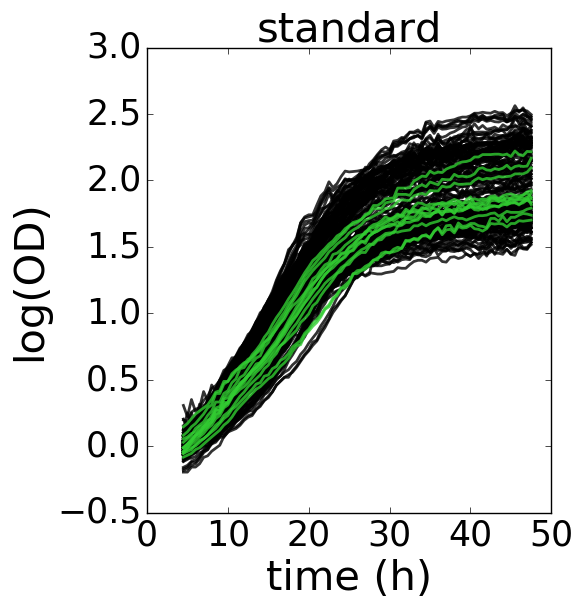

In [40]:
plotConditions(norm,'log2_st0',['standard','paraquat','osmotic','peroxide'])

In [13]:
def plotStressCondition(norm,method,condition):
    
    if not method in os.listdir("figures/data/%s/"%condition):
        os.mkdir("figures/data/%s/"%condition+method)

    paraquat = norm.loc[(norm.standard==1) | (norm[condition]==1),:]
    g = paraquat.groupby('Strain')

    ura3 = g.get_group('ura3')
    g_ura3 = ura3.groupby(['standard'])
    ura3_standard = g_ura3.get_group(1)
    ura3_condition = g_ura3.get_group(0)

    for strain,temp in g:
        #if strain in skip_strains:
        #    continue

        g2 = temp.groupby('standard')
        
        try:
            _standard = g2.get_group(1)
            _condition = g2.get_group(0)
        except:
            continue

    #     g2 = temp.groupby(['Experiment','Well'])

        plt.figure(figsize=(8,6))

        ylim = (min(ura3_standard.OD.min(),ura3_condition.OD.min(),_standard.OD.min(),_condition.OD.min()),
                max(ura3_standard.OD.max(),ura3_condition.OD.max(),_standard.OD.max(),_condition.OD.max()))

#         plt.subplot(121)
#         for well,temp2 in ura3_standard.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

#         for well,temp2 in ura3_paraquat.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(122)
        for well,temp2 in _standard.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

        for well,temp2 in _condition.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(121)
#         plt.title('ura3',fontsize=35)
        plt.ylabel("log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
#         plt.xlim(-1,44)
        plt.ylim(ylim)

#         plt.subplot(122)
#         plt.title(strain,fontsize=35)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.xticks(fontsize=25)
#         plt.grid(True,color='grey')
#         plt.xlim(-1,44)
#         plt.ylim(ylim)

        plt.tight_layout()

        plt.savefig("figures/data/%s/%s/%s"%(condition,method,strain),bbox_inches='tight',dpi=150)
        plt.close()

## Paraquat 

In [14]:
def plot_paraquat(norm,method):
    
    if not method in os.listdir("figures/data/paraquat/"):
        os.mkdir("figures/data/paraquat/"+method)

    paraquat = norm.loc[(norm.standard==1) | (norm.paraquat==1),:]
    g = paraquat.groupby('Strain')

    ura3 = g.get_group('ura3')
    g_ura3 = ura3.groupby(['standard'])
    ura3_standard = g_ura3.get_group(1)
    ura3_paraquat = g_ura3.get_group(0)

    for strain,temp in g:
        #if strain in skip_strains:
        #    continue

        g2 = temp.groupby('standard')
        
        try:
            _standard = g2.get_group(1)
            _paraquat = g2.get_group(0)
        except:
            continue

    #     g2 = temp.groupby(['Experiment','Well'])

        plt.figure(figsize=(8,6))

        ylim = (min(ura3_standard.OD.min(),ura3_paraquat.OD.min(),_standard.OD.min(),_paraquat.OD.min()),
                max(ura3_standard.OD.max(),ura3_paraquat.OD.max(),_standard.OD.max(),_paraquat.OD.max()))

#         plt.subplot(121)
#         for well,temp2 in ura3_standard.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

#         for well,temp2 in ura3_paraquat.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(122)
        for well,temp2 in _standard.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

        for well,temp2 in _paraquat.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(121)
#         plt.title('ura3',fontsize=35)
        plt.ylabel("log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
#         plt.xlim(-1,44)
        plt.ylim(ylim)

#         plt.subplot(122)
#         plt.title(strain,fontsize=35)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.xticks(fontsize=25)
#         plt.grid(True,color='grey')
#         plt.xlim(-1,44)
#         plt.ylim(ylim)

        plt.tight_layout()

        plt.savefig("figures/data/paraquat/%s/%s"%(method,strain),bbox_inches='tight',dpi=150)
        plt.close()

## Osmotic

In [15]:
def plot_osmotic(norm,method):
    
    if not method in os.listdir("figures/data/osmotic/"):
        os.mkdir("figures/data/osmotic/"+method)

    osmotic = norm.loc[(norm.standard==1) | (norm.osmotic==1),:]
    g = osmotic.groupby('Strain')

    ura3 = g.get_group('ura3')
    g_ura3 = ura3.groupby(['standard'])
    ura3_standard = g_ura3.get_group(1)
    ura3_osmotic = g_ura3.get_group(0)

    for strain,temp in g:
        #if strain in skip_strains:
        #    continue

        g2 = temp.groupby('standard')
        
        try:
            _standard = g2.get_group(1)
            _osmotic = g2.get_group(0)
        except:
            continue
                

    #     g2 = temp.groupby(['Experiment','Well'])

        plt.figure(figsize=(8,6))

        ylim = (min(ura3_standard.OD.min(),ura3_osmotic.OD.min(),_standard.OD.min(),_osmotic.OD.min()),
                max(ura3_standard.OD.max(),ura3_osmotic.OD.max(),_standard.OD.max(),_osmotic.OD.max()))

#         plt.subplot(121)
#         for well,temp2 in ura3_standard.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

#         for well,temp2 in ura3_osmotic.groupby(['Experiment','Well']):
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(122)
        for well,temp2 in _standard.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'k',alpha=.6)

        for well,temp2 in _osmotic.groupby(['Experiment','Well']):
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'g',alpha=.6)

#         plt.subplot(121)
#         plt.title('ura3',fontsize=35)
        plt.ylabel("log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
#         plt.xlim(-1,44)
        plt.ylim(ylim)

#         plt.subplot(122)
#         plt.title(strain,fontsize=35)
#     #     plt.ylabel("log(OD)",fontsize=30)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.xticks(fontsize=25)
#         plt.grid(True,color='grey')
#         plt.xlim(-1,44)
#         plt.ylim(ylim)

        plt.tight_layout()

        plt.savefig("figures/data/osmotic/%s/%s"%(method,strain),bbox_inches='tight',dpi=150)
        plt.close()

## Heatshock

In [16]:
def plot_heatshock(norm,method):
    
    if not method in os.listdir("figures/data/heatshock/"):
        os.mkdir("figures/data/heatshock/"+method)

    heatshock = norm[norm.heatshock==1]
    g = heatshock.groupby('Strain')

    ura3 = g.get_group('ura3')
    g_ura3 = ura3.groupby(['Experiment','Well'])

    for strain,temp in g:
        g2 = temp.groupby(['Experiment','Well'])

        plt.figure(figsize=(8,6))
        plt.plot([16,16],[-.2,1.8],'cyan',lw=3)

    #     plt.subplot(121)
#         for well,temp2 in g_ura3:
#             temp2.sort_values('time')
#             plt.plot(temp2.time,temp2.OD,'k',alpha=.2)    

    #     plt.subplot(122)
        for well,temp2 in g2:
            temp2.sort_values('time')
            plt.plot(temp2.time,temp2.OD,'g',alpha=.6)


        plt.title(strain,fontsize=35)

        plt.ylabel("log(OD)",fontsize=30)
        plt.xlabel("time (h)",fontsize=30)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)
        plt.grid(True,color='grey')
#         plt.xlim(-1,28)

        plt.savefig("figures/data/heatshock/%s/%s"%(method,strain),bbox_inches='tight',dpi=150)
        plt.close()

# Normalize 

## Time > 4hrs & < 48 hrs 

In [17]:
# filter all heatshock data after 32 hours
norm = tidy[~((tidy.time>32) & (tidy.heatshock==1))]

In [18]:
g = norm.groupby(['Experiment','Well'])

def time_remove(x):
    
    x = x[x.time>4]
    x = x[x.time<48]
#     x.time = x.time - x.time.values[0]
#     x = x.time
        
    return x

norm = g.apply(time_remove)

## Standard final OD threshold 

In [19]:
g = norm.groupby(['Experiment','Well'])
select = g.apply(lambda x: (x.standard == 1).all() and x.OD.max() - x.OD.min() < 1.0)

temp = select[select]

## Log2 

In [20]:
g = norm.groupby(['Strain','standard','paraquat','peroxide','osmotic','heatshock'])

In [21]:
def normalize(x):
        
    x.OD = np.log2(x.OD)
    # x.OD = x.OD - x.OD[x.time==0].mean()
    return x

norm = g.apply(normalize)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

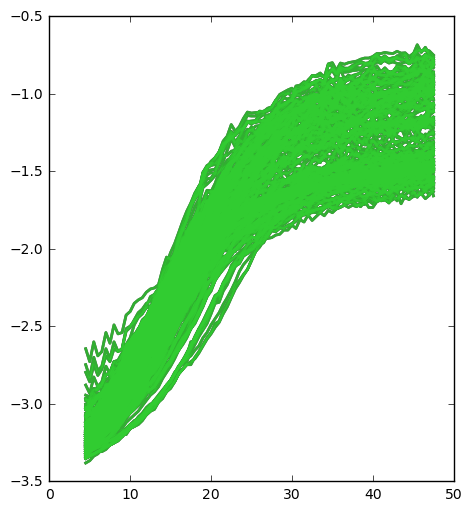

In [22]:
plotConditions(norm,'log2',['standard','paraquat','osmotic','peroxide'])

In [124]:
plot_standard(norm,'log2')
plot_paraquat(norm,'log2')
plot_osmotic(norm,'log2')
plot_heatshock(norm,'log2')
plotStressCondition(norm,'log2','peroxide')

## Experiment effect 

In [ ]:
g = norm.groupby(['Strain','standard','paraquat'])

In [134]:
# temp = g.get_group(('ura3',1,0))
# temp2 = g.get_group(('rosR',1,0))

temp = g.get_group(('ura3',0,1))
temp2 = g.get_group(('rosR',0,1))

temp['ExperimentBio'] = temp.Experiment + temp['Biological replicate']
temp.head()


/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Experiment  Well Strain Biological replicate  \
Experiment Well                                                      
PQ_2       239  23508       PQ_2   239   ura3                    A   
                26112       PQ_2   239   ura3                    A   
                28716       PQ_2   239   ura3                    A   
                31320       PQ_2   239   ura3                    A   
                33924       PQ_2   239   ura3                    A   

                       Technical Replicate  standard  paraquat  peroxide  \
Experiment Well                                                            
PQ_2       239  23508                  NaN         0         1         0   
                26112                  NaN         0         1         0   
                28716                  NaN         0         1         0   
                31320                  NaN         0         1         0   
                33924                  NaN         0         1         0   

                       osmotic  heatshock time        OD ExperimentBio  
Experiment Well                                                         
PQ_2       239  23508        0          0  4.5 -3.184425         PQ_2A  
                26112        0          0    5 -3.158429         PQ_2A  
                28716        0          0  5.5 -3.120294         PQ_2A  
                31320        0          0    6 -3.095420         PQ_2A  
                33924        0          0  6.5 -3.046921         PQ_2A

In [135]:
from matplotlib import colors

In [151]:
def plotReplicates(x,colorby=None,index=None,**kwargs):
    
    g2 = x.groupby(['Experiment','Well'])
    
    if not colorby is None:
        clrs = colors.cnames.keys()[10:-10]
        
        if index is None:
            index = x[colorby].unique().tolist()
        clrs = clrs[::len(clrs)/(len(index)+5)]
    
    for well,temp2 in g2:
        if colorby is None:
            c = 'g'
        else:
            v = temp2[colorby].unique()[0]
            
            if v in index:
                c = clrs[index.index(v)]
            else:
                continue
            
        temp2.sort_values('time')
        plt.plot(temp2.time,temp2.OD,c,**kwargs)
        
    if colorby:
        return index

[u'H2O2_14',
 u'H2O2_15',
 u'H2O2_16',
 u'H2O2_2',
 u'H2O2_6',
 u'H2O2_hrg_compl_1',
 u'PQ_2',
 u'PQ_3',
 u'PQ_4',
 u'PQ_5',
 u'PQ_6',
 u'PQ_7',
 u'PQ_8']

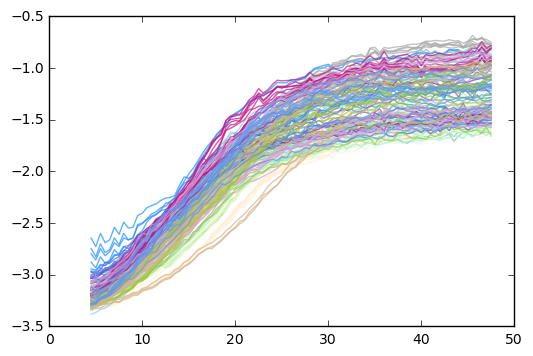

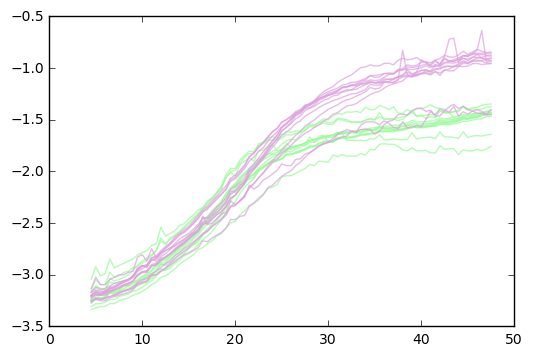

In [167]:
temp = g.get_group(('ura3',1,0))
temp2 = g.get_group(('idr1',1,0))

plt.figure()
index = plotReplicates(temp,colorby='Experiment',alpha=.7);

plt.figure()
plotReplicates(temp2,colorby='Experiment',alpha=.7,index=index)


[u'H2O2_15', u'PQ_5']

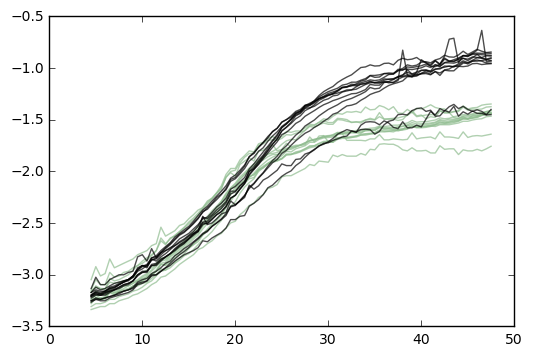

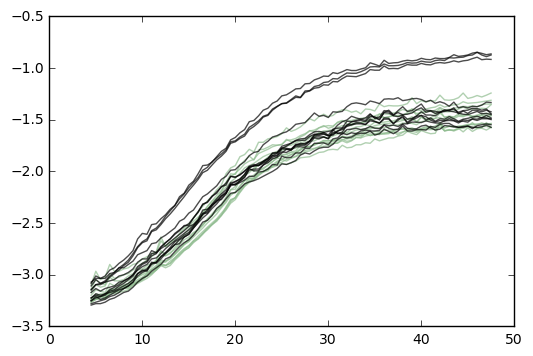

In [168]:
plt.figure()
index = plotReplicates(temp2,colorby='Experiment',alpha=.7);

plt.figure()
plotReplicates(temp,colorby='Experiment',alpha=.7,index=index)

In [147]:
temp = g.get_group(('ura3',0,1))
temp2 = g.get_group(('asnC',0,1))

(-3.5, -1)

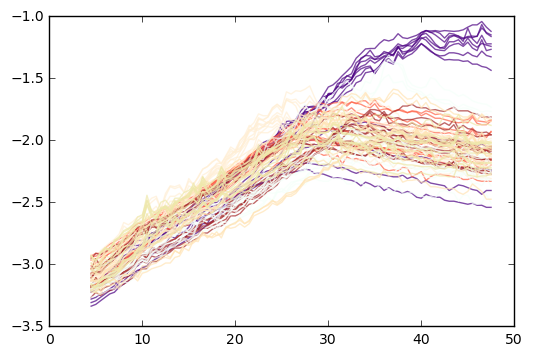

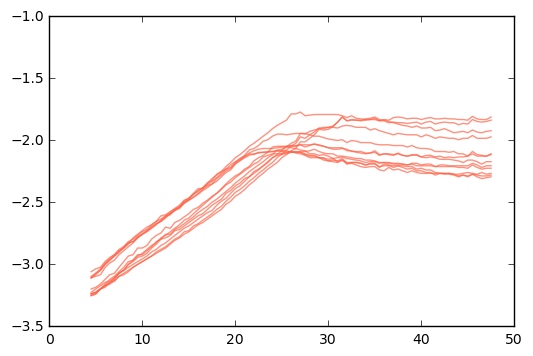

In [148]:
index = plotReplicates(temp,colorby='Experiment',alpha=.7)

plt.figure()
plotReplicates(temp2,colorby='Experiment',index=index,alpha=.7);
plt.ylim(-3.5,-1)

In [ ]:
offsets = {}

g2 = norm.groupby(['Strain'])
ura3 = g2.get_group('ura3')

for cond in ['standard','paraquat','peroxide','osmotic','heatshock']:
    temp = ura3.groupby([cond])
    gura3 = ura3.groupby(['Experiment',cond])

In [102]:
g = norm.groupby(['Strain','Experiment','standard','paraquat','peroxide','osmotic','heatshock'])

g2 = norm.groupby(['Strain'])
ura3 = g2.get_group('ura3')
gura3 = ura3.groupby(['Experiment','standard','paraquat','peroxide','osmotic','heatshock'])

In [ ]:
def experimentEffect(x):
    
    exp = x.Experiment.unique()[0]
    stn = x.standard.unique()[0]
    pq = x.paraquat.unique()[0]
    pr = x.peroxide.unique()[0]
    os = x.osmotic.unique()[0]
    hs = x.heatshock.unique()[0]    
    
    ura = g.get_group(('ura3'))
    
    # find mean at each time point to subtract out before computing replicate effect
    time_group = x.groupby(['time'])
    time_od = time_group.apply(np.mean).OD
    
    def subtract_effect(y):
        select = time_od.index.isin(y.time)
        y.OD = y.OD.values - (y.OD.values-time_od.values[select]).mean()
        return y
    
    replicate_group = x.groupby(['Experiment','Well'])
    return replicate_group.apply(subtract_effect)    

## Subtract $t_0$ 

In [25]:
# g = norm.groupby(['Strain','standard','paraquat','peroxide','osmotic','heatshock'])
g = norm.groupby(['Strain','standard','paraquat','peroxide','osmotic','heatshock','Experiment'])
# g = norm.groupby(['Strain','standard','paraquat','peroxide','osmotic','heatshock','Experiment','Well'])

In [26]:
def normalize(x):
    x.OD = x.OD - x.OD[x.time==x.time.min()].mean()
    # x.OD = x.OD - x.OD[x.time-x.time.min()<2].mean()

    return x

norm = g.apply(normalize)

KeyError: u'ura3_EV'

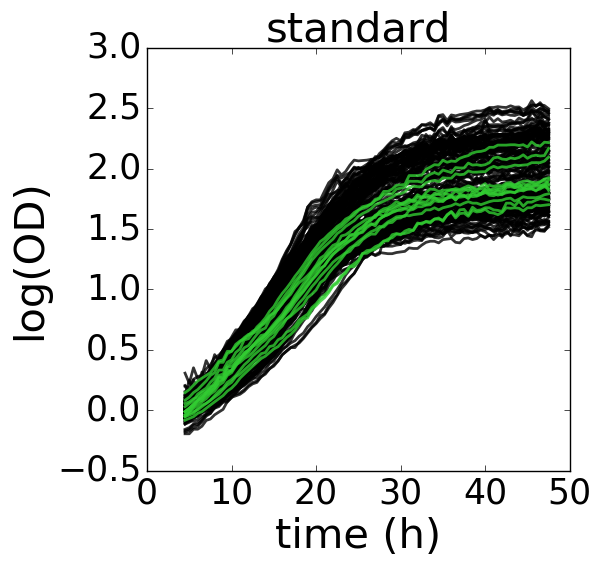

In [28]:
plotConditions(norm,'log2_st0',['standard','paraquat','osmotic','peroxide'],subplots=(2,2))

In [156]:
plot_standard(norm,'log2_st0')
plot_paraquat(norm,'log2_st0')
plot_osmotic(norm,'log2_st0')
plot_heatshock(norm,'log2_st0')
plotStressCondition(norm,'log2_st0','peroxide')

In [49]:
norm.to_csv("data/tidy_normalize_log_st0.csv",index=False)

In [24]:
def plotWells(x,color='b'):
    for well,temp2 in x.groupby(['Experiment','Well']):
        temp2.sort_values('time')
        plt.plot(temp2.time,temp2.OD,color=color,alpha=.6)

## Well correction 

In [25]:
g = norm.groupby(['Strain','standard','paraquat','peroxide','osmotic','heatshock'])

In [26]:
def well_effect(x):
    
    # find mean at each time point to subtract out before computing replicate effect
    time_group = x.groupby(['time'])
    time_od = time_group.apply(np.mean).OD
    
    def subtract_effect(y):
        select = time_od.index.isin(y.time)
        y.OD = y.OD.values - (y.OD.values-time_od.values[select]).mean()
        return y
    
    replicate_group = x.groupby(['Experiment','Well'])
    return replicate_group.apply(subtract_effect)    

In [27]:
norm = g.apply(well_effect)

In [28]:
plot_standard(norm,'log2_well')
plot_paraquat(norm,'log2_well')
plot_osmotic(norm,'log2_well')
plot_heatshock(norm,'log2_well')

# Save 

In [29]:
norm.to_csv("data/tidy_normalize_all.csv",index=False)